In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from datetime import timedelta

from random import uniform
from math import sin, cos, pi
from scipy.stats import wasserstein_distance

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load Prep Data

In [3]:
# Seed used in the preprocessing
seeds = [1415, 9265, 3589, 7932, 3846, 2643, 3832, 7950, 2884, 1971]
seed_index = 9

current_seed = seeds[seed_index]

print(f"Using Preprocessing-Seed {seed_index}: {current_seed}")

Using Preprocessing-Seed 9: 1971


In [4]:
df_original = pd.read_csv(f'/Users/fabian/Downloads/MasterDegree/df_train_{current_seed}.csv')

display(df_original)
unique_vessel_groups_train = df_original['VesselGroup'].unique()
num_vessel_groups_train = df_original['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker
...,...,...,...,...,...,...,...,...
200253,311263000.4,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,ADVENTURE OFTHE SEAS,Passenger
200254,311263000.4,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,ADVENTURE OFTHE SEAS,Passenger
200255,311263000.4,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,ADVENTURE OFTHE SEAS,Passenger
200256,311263000.4,2023-09-23 10:13:50,26.087236,-80.115827,0.252927,132.876412,ADVENTURE OFTHE SEAS,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']


In [5]:
df_group1 = df_original[df_original['VesselGroup'] == unique_vessel_groups_train[0]]
display(df_group1)
df_group2 = df_original[df_original['VesselGroup'] == unique_vessel_groups_train[1]]
display(df_group2)
df_group3 = df_original[df_original['VesselGroup'] == unique_vessel_groups_train[2]]
display(df_group3)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker
...,...,...,...,...,...,...,...,...
66716,538003422.8,2023-05-05 08:39:40,26.259283,-79.019700,10.977106,84.777106,CAPE TALLIN,Tanker
66717,538003422.8,2023-05-05 08:41:40,26.259913,-79.012939,10.986756,84.766889,CAPE TALLIN,Tanker
66718,538003422.8,2023-05-05 08:43:40,26.260546,-79.006186,10.995756,84.784439,CAPE TALLIN,Tanker
66719,538003422.8,2023-05-05 08:45:40,26.261059,-78.999270,10.997054,84.686745,CAPE TALLIN,Tanker


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
66721,3.680338e+08,2023-01-01 00:00:02,29.947540,-90.016440,7.900000,119.400000,EVERETT C,Tug
66722,3.680338e+08,2023-01-01 00:02:02,29.945262,-90.011857,7.986957,119.573913,EVERETT C,Tug
66723,3.680338e+08,2023-01-01 00:04:02,29.942869,-90.007470,7.654000,122.262500,EVERETT C,Tug
66724,3.680338e+08,2023-01-01 00:06:02,29.940700,-90.003569,7.237405,122.989313,EVERETT C,Tug
66725,3.680338e+08,2023-01-01 00:08:02,29.938458,-89.999784,6.984000,122.257538,EVERETT C,Tug
...,...,...,...,...,...,...,...,...
133444,3.682810e+08,2023-08-04 23:50:55,45.537338,-122.681322,0.488146,47.666087,CINDY B,Tug
133445,3.682810e+08,2023-08-04 23:52:55,45.537700,-122.681721,0.602620,40.818385,CINDY B,Tug
133446,3.682810e+08,2023-08-04 23:54:55,45.537982,-122.682081,0.516267,32.316243,CINDY B,Tug
133447,3.682810e+08,2023-08-04 23:56:55,45.538137,-122.681759,0.426055,117.478908,CINDY B,Tug


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
133449,3.160013e+08,2023-01-01 23:14:31,49.434800,-123.471600,0.600000,102.700000,QUEEN OF SURREY,Passenger
133450,3.160013e+08,2023-01-01 23:16:31,49.436208,-123.468424,6.600000,97.100000,QUEEN OF SURREY,Passenger
133451,3.160013e+08,2023-01-01 23:18:31,49.432053,-123.461967,15.049735,122.565608,QUEEN OF SURREY,Passenger
133452,3.160013e+08,2023-01-01 23:20:31,49.426021,-123.452637,14.044853,111.527206,QUEEN OF SURREY,Passenger
133453,3.160013e+08,2023-01-01 23:22:31,49.422045,-123.441797,15.621455,96.546909,QUEEN OF SURREY,Passenger
...,...,...,...,...,...,...,...,...
200253,3.112630e+08,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,ADVENTURE OFTHE SEAS,Passenger
200254,3.112630e+08,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,ADVENTURE OFTHE SEAS,Passenger
200255,3.112630e+08,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,ADVENTURE OFTHE SEAS,Passenger
200256,3.112630e+08,2023-09-23 10:13:50,26.087236,-80.115827,0.252927,132.876412,ADVENTURE OFTHE SEAS,Passenger


# On-cricle augmentation

In [6]:
def augment_trajectories(df_original, aug_size, num_copies, radius_meters, noise_percent):
    """
    Augment trajectories to create a new dataset with specific total rows.

    Parameters:
        df_original (pd.DataFrame): Original dataset containing trajectories.
        aug_size (int): Desired size of augmented data (number of rows).
        num_copies (int): Number of copies per trajectory.
        radius_meters (float): Radius in meters for noise adjustment.
        noise_percent (float): Percentage of points per trajectory to adjust.

    Returns:
        pd.DataFrame: Augmented dataset.
    """
    augmented_data = []
    vessel_groups = df_original['VesselGroup'].unique()
    rows_per_group = aug_size // len(vessel_groups)

    highest_mmsi = df_original['MMSI'].max()
    new_mmsi_counter = highest_mmsi + 1  

    for group in vessel_groups:
        group_data = df_original[df_original['VesselGroup'] == group]
        unique_mmsis = group_data['MMSI'].unique()
        rows_created = 0

        while rows_created < rows_per_group:
            for mmsi in unique_mmsis:
                if rows_created >= rows_per_group:
                    break
                
                trajectory_data = group_data[group_data['MMSI'] == mmsi]
                trajectory_points = trajectory_data[['LAT', 'LON']].values

                for _ in range(num_copies):
                    if rows_created >= rows_per_group:
                        break

                    augmented_trajectory = trajectory_data.copy()
                    modified_points = trajectory_points.copy()

                    augmented_trajectory['OriginalMMSI'] = mmsi

                    augmented_trajectory['MMSI'] = new_mmsi_counter
                    augmented_trajectory['VesselName'] = f"Augmented {group}"
                    new_mmsi_counter += 1 

                    num_points_to_modify = int(len(trajectory_points) * noise_percent)
                    selected_points = np.random.choice(len(trajectory_points), num_points_to_modify, replace=False)

                    for point_idx in selected_points:
                        point = modified_points[point_idx]
                        angle = uniform(0, 2 * pi)
                        radius_deg = radius_meters / 111320
                        modified_points[point_idx] = [
                            point[0] + radius_deg * cos(angle),
                            point[1] + radius_deg * sin(angle) 
                        ]

                    augmented_trajectory[['LAT', 'LON']] = modified_points
                    augmented_data.append(augmented_trajectory)
                    rows_created += len(augmented_trajectory)

                    if rows_created >= rows_per_group:
                        break

    augmented_df = pd.concat(augmented_data, ignore_index=True)
    print(f"Augmented DataFrame created with {len(augmented_df)} rows.")
    display(augmented_df)
    return augmented_df

augmentation_sizes = [50000, 100000, 150000, 200000]
augmented_datasets = []
quantitative_results = [] 

for aug_size in augmentation_sizes:
    print(f"\n--- Augmenting data for augmentation size: {aug_size} ---")
    augmented_df = augment_trajectories(
        df_original,            # Original dataset
        aug_size=aug_size,      # Total rows of augmented data
        num_copies=1,           # Number of copies per trajectory
        radius_meters=15,       # Adjust positions within a X radius
        noise_percent=0.3       # Modify X % of points in each trajectory
    )
    
    df_combined = pd.concat([df_original, augmented_df], ignore_index=True)
    print(f"Combined DataFrame created with {len(df_combined)} rows.")
    display(df_combined)


    """
    # Apply UMAP
    print("Applying UMAP for dimensionality reduction...")
    features = ['LAT', 'LON', 'SOG', 'COG']  # Use LAT, LON, SOG, and COG for UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
    X_combined = df_combined[features].fillna(0)  # Handle missing values if any
    X_umap = umap_reducer.fit_transform(X_combined)
    df_combined['umap_dim1'], df_combined['umap_dim2'] = X_umap[:, 0], X_umap[:, 1]

    # Split UMAP data for Wasserstein Distance calculation
    df_original_umap = df_combined[df_combined['MMSI'].isin(df_original['MMSI'])]
    df_augmented_umap = df_combined[~df_combined['MMSI'].isin(df_original['MMSI'])]
    wd_dim1 = wasserstein_distance(df_original_umap['umap_dim1'], df_augmented_umap['umap_dim1'])
    wd_dim2 = wasserstein_distance(df_original_umap['umap_dim2'], df_augmented_umap['umap_dim2'])
    print(f"Wasserstein Distance (Dimension 1): {wd_dim1}")
    print(f"Wasserstein Distance (Dimension 2): {wd_dim2}")
    quantitative_results.append({
        'augmentation_size': aug_size,
        'wasserstein_dim1': wd_dim1,
        'wasserstein_dim2': wd_dim2
    })

    # Plot UMAP visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_combined,
        x='umap_dim1', 
        y='umap_dim2',
        hue=df_combined['MMSI'].isin(df_original['MMSI']).map({True: 'Original', False: 'Augmented'}),
        alpha=0.5
    )
    plt.title(f"UMAP Visualization: Original vs Augmented (Rows: {aug_size})")
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    

    base_dir = f'/Users/fabian/Downloads/MasterDegree/GNI/GNI{current_seed}'
    file_name = f'df_GNI_{aug_size}.csv'
    file_path = os.path.join(base_dir, file_name)

    os.makedirs(base_dir, exist_ok=True)

    df_combined.to_csv(file_path, index=False)

    print(f"Saved combined dataset with approximately {aug_size} augmented rows and in sum {len(df_combined)} rows to '{file_name}'.")

    augmented_datasets.append(df_combined)

quantitative_df = pd.DataFrame(quantitative_results)
print("\nQuantitative Results:")
display(quantitative_df)


--- Augmenting data for augmentation size: 50000 ---
Augmented DataFrame created with 50725 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,730152434.1,2023-05-05 21:39:27,29.747243,-95.098299,0.600000,270.200000,Augmented Tanker,Tanker,538005775.1
1,730152434.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,Augmented Tanker,Tanker,538005775.1
2,730152434.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,Augmented Tanker,Tanker,538005775.1
3,730152434.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,Augmented Tanker,Tanker,538005775.1
4,730152434.1,2023-05-05 21:47:27,29.748062,-95.099261,2.319033,88.353172,Augmented Tanker,Tanker,538005775.1
...,...,...,...,...,...,...,...,...,...
50720,730153030.1,2023-05-05 14:09:40,40.763377,-74.013927,15.852839,16.629305,Augmented Passenger,Passenger,367482250.2
50721,730153030.1,2023-05-05 14:11:40,40.766955,-74.013408,4.154101,9.171172,Augmented Passenger,Passenger,367482250.2
50722,730153030.1,2023-05-05 14:13:40,40.768761,-74.013086,4.794284,16.393014,Augmented Passenger,Passenger,367482250.2
50723,730153030.1,2023-05-05 14:15:40,40.771122,-74.012417,1.694968,323.183032,Augmented Passenger,Passenger,367482250.2


Combined DataFrame created with 250983 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker,NaN
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker,NaN
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker,NaN
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker,NaN
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker,NaN
...,...,...,...,...,...,...,...,...,...
250978,730153030.1,2023-05-05 14:09:40,40.763377,-74.013927,15.852839,16.629305,Augmented Passenger,Passenger,367482250.2
250979,730153030.1,2023-05-05 14:11:40,40.766955,-74.013408,4.154101,9.171172,Augmented Passenger,Passenger,367482250.2
250980,730153030.1,2023-05-05 14:13:40,40.768761,-74.013086,4.794284,16.393014,Augmented Passenger,Passenger,367482250.2
250981,730153030.1,2023-05-05 14:15:40,40.771122,-74.012417,1.694968,323.183032,Augmented Passenger,Passenger,367482250.2


Saved combined dataset with approximately 50000 augmented rows and in sum 250983 rows to 'df_GNI_50000.csv'.

--- Augmenting data for augmentation size: 100000 ---
Augmented DataFrame created with 100189 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,730152434.1,2023-05-05 21:39:27,29.747236,-95.098368,0.600000,270.200000,Augmented Tanker,Tanker,538005775.1
1,730152434.1,2023-05-05 21:41:27,29.747235,-95.099024,0.938028,286.171831,Augmented Tanker,Tanker,538005775.1
2,730152434.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,Augmented Tanker,Tanker,538005775.1
3,730152434.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,Augmented Tanker,Tanker,538005775.1
4,730152434.1,2023-05-05 21:47:27,29.748088,-95.099520,2.319033,88.353172,Augmented Tanker,Tanker,538005775.1
...,...,...,...,...,...,...,...,...,...
100184,730153590.1,2023-08-04 17:38:11,48.560260,-122.589259,25.600000,150.100000,Augmented Passenger,Passenger,338203383.5
100185,730153590.1,2023-08-04 17:40:11,48.553867,-122.583503,24.500000,146.600000,Augmented Passenger,Passenger,338203383.5
100186,730153590.1,2023-08-04 17:42:11,48.547050,-122.577830,25.500000,159.900000,Augmented Passenger,Passenger,338203383.5
100187,730153590.1,2023-08-04 17:44:11,48.539860,-122.574360,24.800000,165.700000,Augmented Passenger,Passenger,338203383.5


Combined DataFrame created with 300447 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker,NaN
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker,NaN
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker,NaN
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker,NaN
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker,NaN
...,...,...,...,...,...,...,...,...,...
300442,730153590.1,2023-08-04 17:38:11,48.560260,-122.589259,25.600000,150.100000,Augmented Passenger,Passenger,338203383.5
300443,730153590.1,2023-08-04 17:40:11,48.553867,-122.583503,24.500000,146.600000,Augmented Passenger,Passenger,338203383.5
300444,730153590.1,2023-08-04 17:42:11,48.547050,-122.577830,25.500000,159.900000,Augmented Passenger,Passenger,338203383.5
300445,730153590.1,2023-08-04 17:44:11,48.539860,-122.574360,24.800000,165.700000,Augmented Passenger,Passenger,338203383.5


Saved combined dataset with approximately 100000 augmented rows and in sum 300447 rows to 'df_GNI_100000.csv'.

--- Augmenting data for augmentation size: 150000 ---
Augmented DataFrame created with 150124 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,730152434.1,2023-05-05 21:39:27,29.747089,-95.098453,0.600000,270.200000,Augmented Tanker,Tanker,5.380058e+08
1,730152434.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,Augmented Tanker,Tanker,5.380058e+08
2,730152434.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,Augmented Tanker,Tanker,5.380058e+08
3,730152434.1,2023-05-05 21:45:27,29.747403,-95.099950,0.419772,190.295437,Augmented Tanker,Tanker,5.380058e+08
4,730152434.1,2023-05-05 21:47:27,29.748039,-95.099259,2.319033,88.353172,Augmented Tanker,Tanker,5.380058e+08
...,...,...,...,...,...,...,...,...,...
150119,730154127.1,2023-12-14 22:07:58,40.747410,-74.010220,0.100000,73.600000,Augmented Passenger,Passenger,3.675865e+08
150120,730154127.1,2023-12-14 22:09:58,40.747410,-74.010220,0.100000,27.500000,Augmented Passenger,Passenger,3.675865e+08
150121,730154127.1,2023-12-14 22:11:58,40.747527,-74.010277,0.100000,16.000000,Augmented Passenger,Passenger,3.675865e+08
150122,730154127.1,2023-12-14 22:13:58,40.747410,-74.010230,0.300000,72.300000,Augmented Passenger,Passenger,3.675865e+08


Combined DataFrame created with 350382 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker,NaN
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker,NaN
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker,NaN
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker,NaN
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker,NaN
...,...,...,...,...,...,...,...,...,...
350377,730154127.1,2023-12-14 22:07:58,40.747410,-74.010220,0.100000,73.600000,Augmented Passenger,Passenger,3.675865e+08
350378,730154127.1,2023-12-14 22:09:58,40.747410,-74.010220,0.100000,27.500000,Augmented Passenger,Passenger,3.675865e+08
350379,730154127.1,2023-12-14 22:11:58,40.747527,-74.010277,0.100000,16.000000,Augmented Passenger,Passenger,3.675865e+08
350380,730154127.1,2023-12-14 22:13:58,40.747410,-74.010230,0.300000,72.300000,Augmented Passenger,Passenger,3.675865e+08


Saved combined dataset with approximately 150000 augmented rows and in sum 350382 rows to 'df_GNI_150000.csv'.

--- Augmenting data for augmentation size: 200000 ---
Augmented DataFrame created with 200258 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,730152434.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,Augmented Tanker,Tanker,538005775.1
1,730152434.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,Augmented Tanker,Tanker,538005775.1
2,730152434.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,Augmented Tanker,Tanker,538005775.1
3,730152434.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,Augmented Tanker,Tanker,538005775.1
4,730152434.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,Augmented Tanker,Tanker,538005775.1
...,...,...,...,...,...,...,...,...,...
200253,730154680.1,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,Augmented Passenger,Passenger,311263000.4
200254,730154680.1,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,Augmented Passenger,Passenger,311263000.4
200255,730154680.1,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,Augmented Passenger,Passenger,311263000.4
200256,730154680.1,2023-09-23 10:13:50,26.087367,-80.115857,0.252927,132.876412,Augmented Passenger,Passenger,311263000.4


Combined DataFrame created with 400516 rows.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup,OriginalMMSI
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker,NaN
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker,NaN
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker,NaN
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker,NaN
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker,NaN
...,...,...,...,...,...,...,...,...,...
400511,730154680.1,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,Augmented Passenger,Passenger,311263000.4
400512,730154680.1,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,Augmented Passenger,Passenger,311263000.4
400513,730154680.1,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,Augmented Passenger,Passenger,311263000.4
400514,730154680.1,2023-09-23 10:13:50,26.087367,-80.115857,0.252927,132.876412,Augmented Passenger,Passenger,311263000.4


Saved combined dataset with approximately 200000 augmented rows and in sum 400516 rows to 'df_GNI_200000.csv'.

Quantitative Results:


""


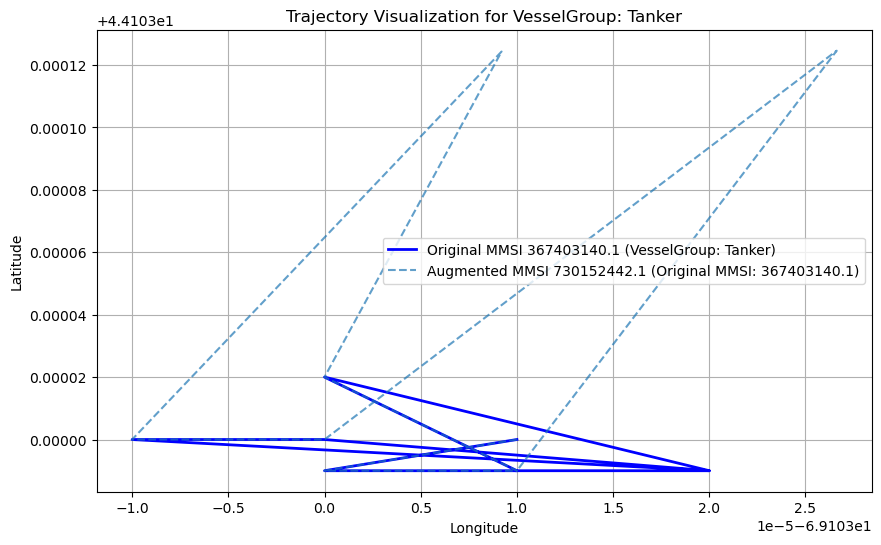

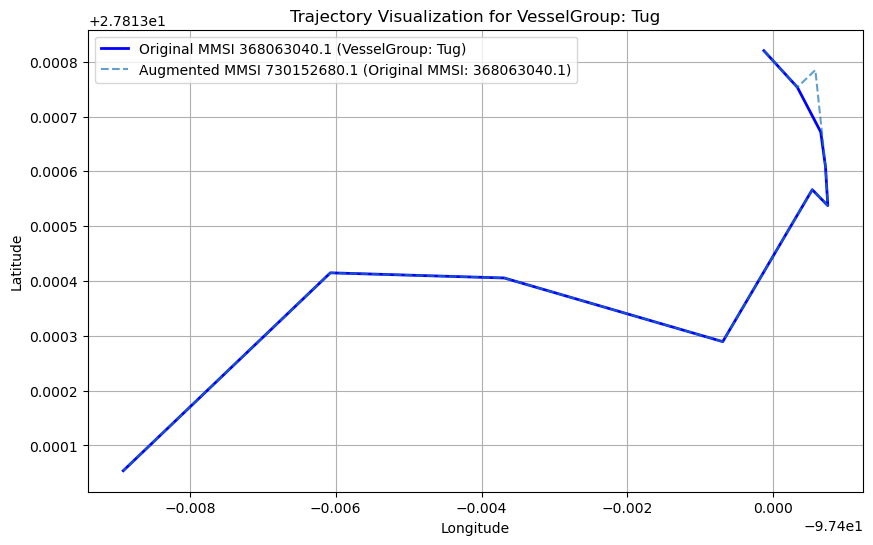

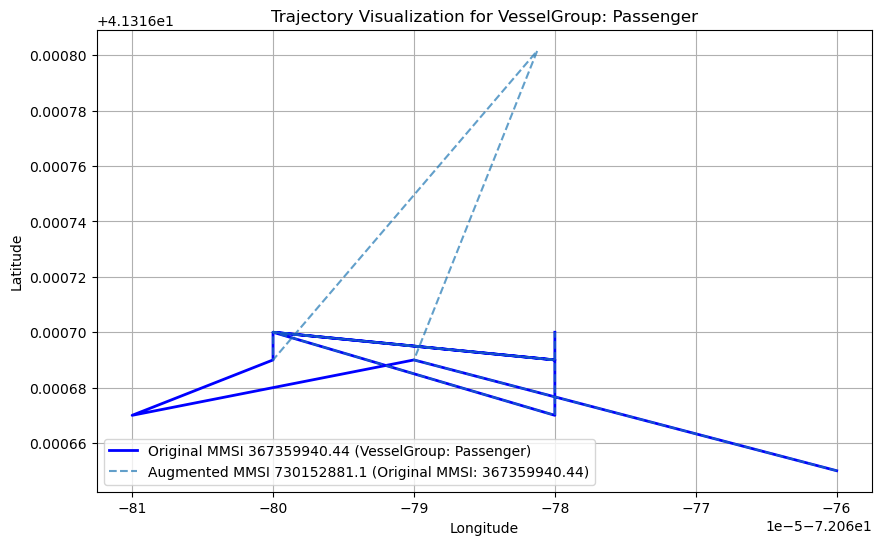

In [7]:
import matplotlib.pyplot as plt
import random

def plot_random_per_vesselgroup(df_original, df_augmented, num_points):
    """
    Plot one random original and augmented trajectory for each VesselGroup.

    Parameters:
        df_original (pd.DataFrame): Original dataset containing trajectories.
        df_augmented (pd.DataFrame): Augmented dataset containing trajectories.
        num_points (int): Number of points to display per trajectory.
    """
    vessel_groups = df_augmented['VesselGroup'].unique()

    for vessel_group in vessel_groups:
        original_mmsis = df_augmented[df_augmented['VesselGroup'] == vessel_group]['OriginalMMSI'].unique()
        
        if len(original_mmsis) == 0:
            print(f"No Original MMSI found for VesselGroup: {vessel_group}")
            continue
        
        mmsi = random.choice(original_mmsis)

        original_trajectory = df_original[df_original['MMSI'] == mmsi][['LAT', 'LON', 'VesselGroup']].head(num_points)

        augmented_trajectories = df_augmented[df_augmented['OriginalMMSI'] == mmsi]

        plt.figure(figsize=(10, 6))

        plt.plot(
            original_trajectory['LON'],
            original_trajectory['LAT'],
            label=f"Original MMSI {mmsi} (VesselGroup: {vessel_group})",
            color='blue',
            linewidth=2
        )

        for augmented_mmsi in augmented_trajectories['MMSI'].unique():
            augmented_trajectory = augmented_trajectories[augmented_trajectories['MMSI'] == augmented_mmsi][['LAT', 'LON']].head(num_points)
            plt.plot(
                augmented_trajectory['LON'],
                augmented_trajectory['LAT'],
                label=f"Augmented MMSI {augmented_mmsi} (Original MMSI: {mmsi})",
                linestyle='--',
                alpha=0.7,
                linewidth=1.5
            )

        plt.title(f"Trajectory Visualization for VesselGroup: {vessel_group}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid(True)
        plt.show()

df_combined = augmented_datasets[0]

df_augmented = df_combined[df_combined['OriginalMMSI'].notnull()]

plot_random_per_vesselgroup(df_original, df_augmented, num_points=10)